In [8]:
import pandas as pd
import numpy as np

file_path = 'C:/Users/lalaj/PycharmProjects/untitled3/read_clustering/tests/test_files/native_cbf5_gal.csv'

from read_clustering.variant_call import VariantCall

In [12]:
    def __init__(self, file_path):
        self.data = pd.read_csv(file_path)
        self.canonical = {"A", "C", "G", "T"}
        
        
    def variants_for_position(self, position):
        """return number of different variants, contigs, and strands per position to check if there could be a mismatch"""
        base_data = self.data[self.data['reference_index'] == position]
        data = base_data.groupby(['contig', 'strand', 'variants']).nunique()
        return data
    
    def get_plot_df(self, positions, variant_sets):
        """return dataframe with probabilities for the modified variants in the given positions for each read
        Params: positions: target positions as a list
                variants: target variants as a list
        Returns: df_plot: dataframe with 'read id' and corresponding probability data to plot
        """
        data = self.data[(self.data['reference_index'].isin (positions)) & (self.data['variants'].isin (variant_sets))]
        plot_data = data.loc[:,['read_id', 'reference_index', 'variants', 'prob1', 'prob2']]
        pos_n = len(positions)
        var_n = len(variant_sets)
        select = plot_data.groupby(['read_id']).nunique()     
        
        a = select[(select['reference_index'] == pos_n) & (select['variants'] == var_n)]
        a.columns = ['id_number', 'reference_index', 'variants', 'prob1', 'prob2']
        target_ids = list(a.index.values)        
        prob_866 = []
        prob_875 = []
        for i in target_ids:
            r = (plot_data.loc[plot_data['read_id'] == i]).reset_index(drop=True)    
            prob_866.append(r.loc[0, 'prob2'])
            prob_875.append(r.loc[1, 'prob2'])
        
        df_plot = pd.DataFrame(list(zip(target_ids, prob_866, prob_875))) 
        df_plot.columns = ['read id', 'P 866 (Gc)', 'P 875 (Aa)']        #desired column name          
        return df_plot

In [13]:
native = VariantCall(file_path)      #create instance with the dataset

In [14]:
native.variants_for_position(866)

,,,read_id,contig,reference_index,strand,variants,prob1,prob2,prob3
contig,strand,variants,,,,,,,,
RDN25-1,+,Gc,792,1,1,1,1,737,737,1


In [15]:
native.variants_for_position(875)

,,,read_id,contig,reference_index,strand,variants,prob1,prob2,prob3
contig,strand,variants,,,,,,,,
RDN25-1,+,Aa,792,1,1,1,1,359,359,1


Having verified that there are no mismatches in the datasets I can now plot and cluster them.  

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
plt.rcParams['figure.figsize'] = [15, 8]

In [18]:
plot_df = native.get_plot_df([866, 875],['Gc', 'Aa'])
plot_df

,read id,P 866 (Gc),P 875 (Aa)
0,000ac297-5ebe-4a01-b9f0-3d3154895f94,0.951187,0.995382
1,000c90c4-a0a3-4c79-98f3-e5029a2e5c1b,0.628240,1.000000
2,00119d0a-483a-451b-b915-20322944ee46,0.929846,0.000000
3,002bfe8f-dc4e-4e74-bbb2-88df2669d95f,0.912648,0.826865
4,009ee3d2-06c8-4b53-8352-eb717ecfe315,0.830581,0.755623
...,...,...,...
787,fde737a2-3779-4fcc-9c5a-a2e543ac968c,0.961212,0.148345
788,fefb3af0-0e2d-4e38-a3e4-54860f40100b,0.936195,1.000000
789,fefd255e-1d87-4e2b-b03e-02b3c3e0b349,0.618615,1.000000
790,ff966e97-a60b-4e3d-9806-c38635b67335,0.848287,1.000000


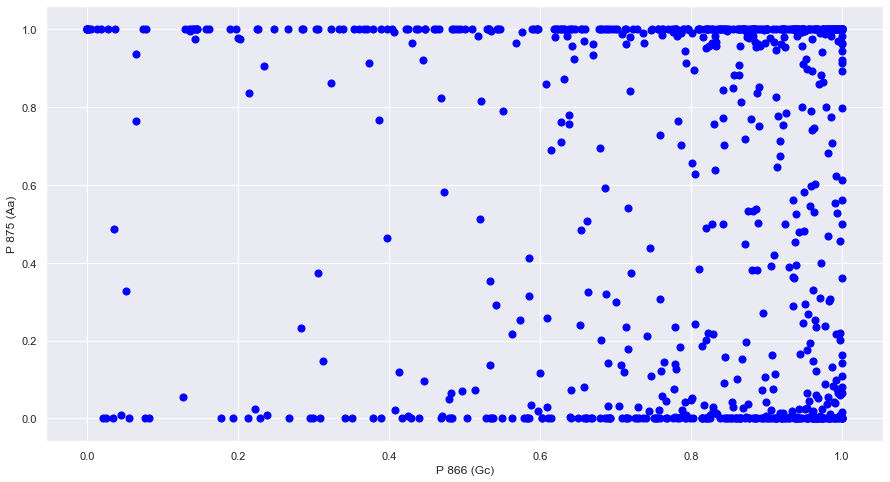

In [19]:
cluster1 = plot_df.plot.scatter(x='P 866 (Gc)',
                      y='P 875 (Aa)', c = 'blue', s=50)

Now apply ML K-means classifier. Unsupervised (no labels) ML model.

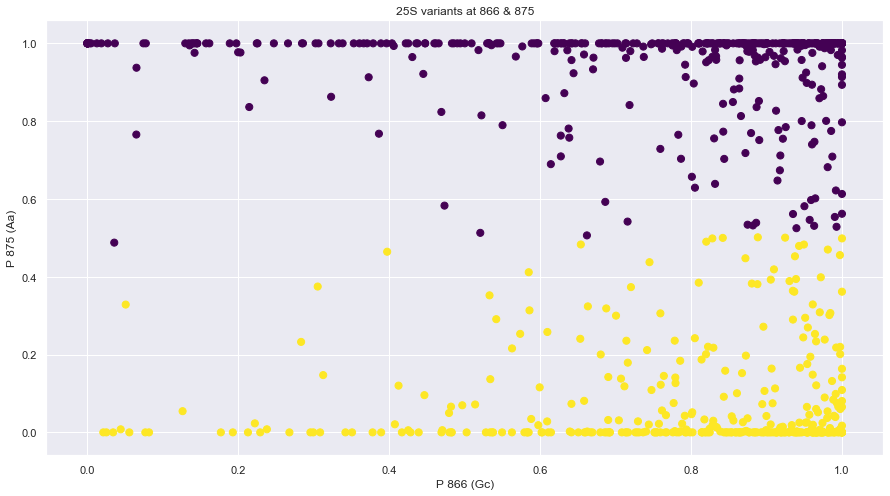

In [20]:
from sklearn.cluster import KMeans

#With 2 clusters
z = plot_df.loc[:, ['P 866 (Gc)', 'P 875 (Aa)']]  #slice to get only 2 columns
X = z.values
kmeans = KMeans(n_clusters=2)             #adjust number of clusters wanted
kmeans.fit(X)
y_kmeans = kmeans.predict(X)


plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.title("25S variants at 866 & 875")
plt.xlabel('P 866 (Gc)')
plt.ylabel('P 875 (Aa)')
plt.show()

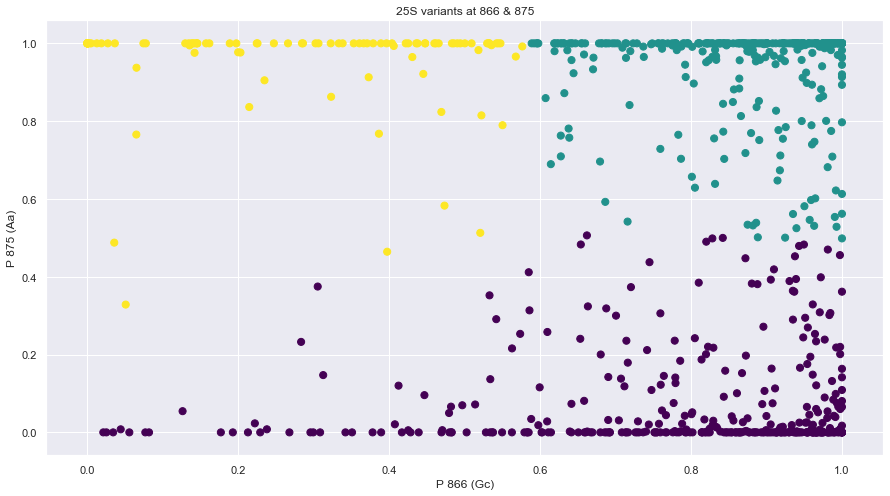

In [21]:
#With 3 clusters
z = plot_df.loc[:, ['P 866 (Gc)', 'P 875 (Aa)']]  
X = z.values
kmeans = KMeans(n_clusters=3)             
kmeans.fit(X)
y_kmeans = kmeans.predict(X)


plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.title("25S variants at 866 & 875")
plt.xlabel('P 866 (Gc)')
plt.ylabel('P 875 (Aa)')
plt.show()

We can try too with Gaussian mixture models (unupervised too), and has less limitations than K means.

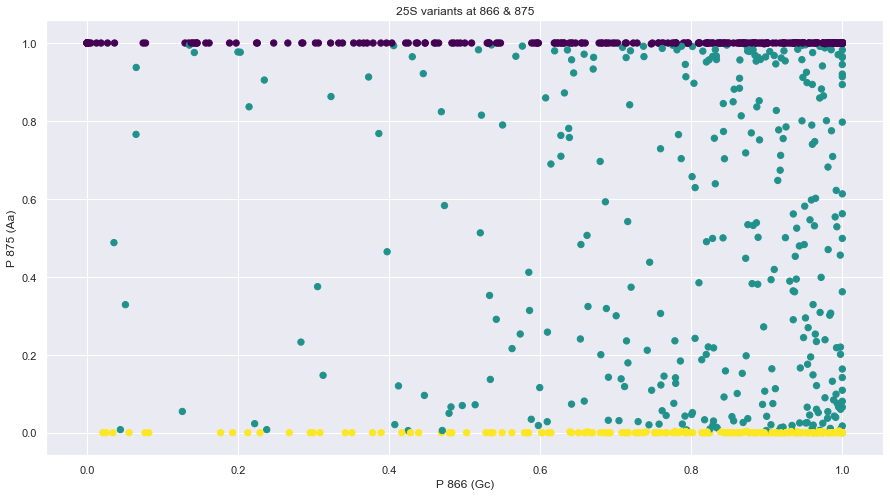

In [22]:
from sklearn.mixture import GaussianMixture

#with 3 clusters
gmm = GaussianMixture(n_components=3).fit(X)     #adjust number of clusters wanted
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');
plt.title("25S variants at 866 & 875")
plt.xlabel('P 866 (Gc)')
plt.ylabel('P 875 (Aa)')
plt.show()

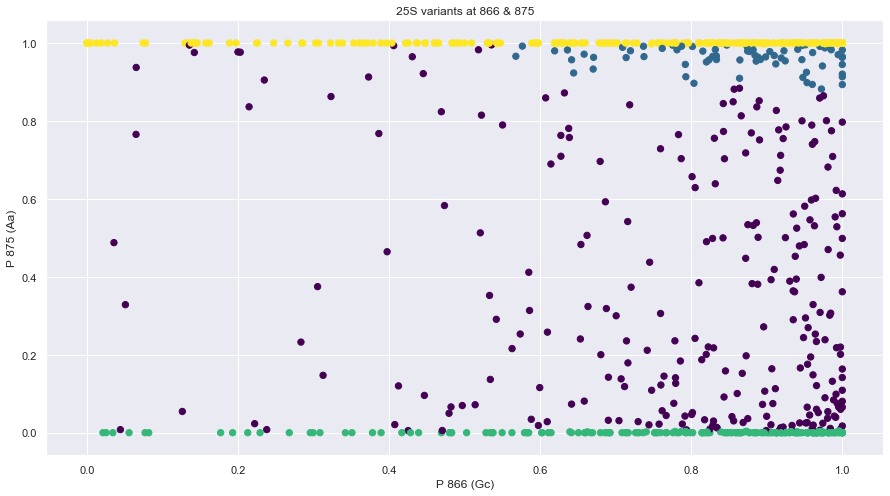

In [24]:
#with 4 clusters
gmm = GaussianMixture(n_components=4).fit(X)     #adjust number of clusters wanted
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');
plt.title("25S variants at 866 & 875")
plt.xlabel('P 866 (Gc)')
plt.ylabel('P 875 (Aa)')
plt.show()